# MCMC for weibull prior and poisson likelihood

<!-- ![gamblimg machine](https://image.made-in-china.com/44f3j00IumtHGLCabcD/American-Original-Touch-Screen-Casino-Games-Cabinets-Slot-Gambling-Machine.jpg) -->
<center>
 <img src="https://image.made-in-china.com/44f3j00IumtHGLCabcD/American-Original-Touch-Screen-Casino-Games-Cabinets-Slot-Gambling-Machine.jpg" alt="Girl in a jacket" width="80%"> </center>


In [9]:
# import libraries
import jax
import jax.numpy as jnp
try:
  import distrax
except:
  %pip install -qq distrax
  import distrax
import tensorflow as tf

import tensorflow_probability.substrates.jax as tfp
tfd = tfp.distributions
try:
    import blackjax
except:
    %pip install -qq blackjax
    import blackjax
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from rmh import rmh_inference_loop,plot_rmh
import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())
# jax.config.update("jax_enable_x64", True)

In [11]:
with open("../data/weibull_poisson/weibull_poisson",'rb') as f:
    data = pickle.load(f)
samples = jnp.array(data['data'])
lamda = data['prior']['lamda']
k = data['prior']['k']

We have samples from the poisson distribution. But lets say we didn't know the parameter of the distribution that had given us the samples. So we want the answer here to be 10. 

The poisson distribution has the pdf
\begin{equation}
f(x;μ) = \frac{\mu^xe^{− \mu}}{x !}
\end{equation}

Lets generate samples now.

What am I saying? just sample 2000 points? and then don't visualize it?




Of course not. Lets see the histogram.

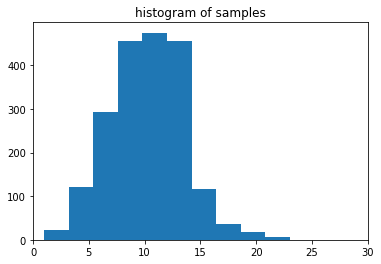

In [12]:
plt.hist(samples)
plt.xlim(0,30)
plt.title("histogram of samples")
plt.show()

Now the fun(trouble) begins!

So we assume the prior here to be a weibull distribution. It has parameters $λ,k$ which signify scale and shape respectively.

The distribution is very dangerous. So lets just see the pdf (which we need) and move on.

\begin{equation}
    f(x;λ,k)=
    \begin{cases}
      \frac{k}{λ}\left(\frac{x}{λ}\right)^ke^{-(x/λ)^k}&,  \text{if}\ x\ge1 \\
      0 &,  \text{if}\ x<0
    \end{cases}
\end{equation}

Lets now look at how pdf varies if we vary the parameters of the funtion.

In [13]:
 
lamda = 10
k = 15
wiebull = tfd.Weibull(lamda,k)
@widgets.interact(lamda=(0,20,0.2),k=(0,20,0.2))
def plot_weibull(lamda=10,k=15):
  wiebull = tfd.Weibull(lamda,k)
  x = jnp.linspace(-5,20,100)
  wiebull_pdf = wiebull.prob(x)
  plt.plot(x,wiebull_pdf)
  plt.title('Prior PDF')
  plt.ylim(0,0.3)
  # plt.show()

interactive(children=(FloatSlider(value=10.0, description='lamda', max=20.0, step=0.2), FloatSlider(value=15.0…

okay. So this is our scary prior. Now think about how scary would prior*likelihood term look.

Did you think? Now think about how would the integration for normalizing constant(evidence term) look like?

Scared?

That's why we don't do that integration. We just do Markov Chain Monte Carlo (MCMC).

Specifically we are going to use the Metropolis-hasting algorithm here. I like this algorithm because we don't need the evidence term(the normalizing constant) inorder to sample from posterior distribution.

In the blackjax implementation, we need to give the log of numerator term in the posterior distribution.

The log of the posterior will be the sum of log likelihood and log of prior pdf.

* The log pdf of the weibull distribution will be



\begin{equation}
log(f(x| λ,k) = -\left(\frac{x}{λ}\right)^k+ (k-1)(logx-logλ) + logk-logλ
\end{equation}

* We will just calculate the log likelihood using the jax funtions.
<br><br>

So now lets just write the funtion for calculating the numerator term.

In [14]:
lamda = jnp.array([10.0])
# lamda = 10.0  --- This was giving some problems. Anyways

samples = jnp.array(samples)

def log_postfn(x):
  # from the above equation
  # log_prior = -(x/lamda)**k+ (k-1)*(jnp.log(x)-jnp.log(lamda)) +jnp.log(k/lamda)
  log_prior = wiebull.log_prob(x)
  # log_likelihood
  log_like = jnp.array([jnp.sum(jax.scipy.stats.poisson.logpmf(samples,x))])
  poisso = tfd.Poisson(rate=x)
  # log_like = jnp.sum(poisso.log_prob(samples))
  return (log_like+log_prior)[0]

log_postfn(1)


DeviceArray(-33607.637, dtype=float32)

RMH here stands for Random walk Metropolis Hastings.
We will use the blackjax implementation of it.

Things we have to do using jax


*   rmh takes the log of posterior pdf and sigma is the walk length parameter. So give them.
*   Then define the initial state of the rmh. This is done by just giving the initial value of whatever we are trying to estimate.




In [15]:
rmh = blackjax.rmh(log_postfn, sigma = jnp.array([0.1]))
m = jnp.array([1.0])
initial_state = rmh.init(m)
initial_state

RMHState(position=DeviceArray([1.], dtype=float32), log_probability=DeviceArray(-33607.637, dtype=float32))

I don't have a good idea of how the below fn works but it will give us the samples that we need.

In [16]:
def inference_loop(rng_key, kernel, initial_state, num_samples):
    @jax.jit
    def one_step(state, rng_key):
        state, _ = kernel(rng_key, state)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

Lets generate samples from posterior distribution now.

In [17]:
rng_key = jax.random.PRNGKey(0)
_, rng_key = jax.random.split(rng_key)
states = inference_loop(rng_key, rmh.step, initial_state, 1000)

lets now see how it is varying. As we can see from the below figure, the parameter is changing a lot durin the first 300 iterations and then having a stationary distribution. So we eliminate the first 300 samples and then just take a target distribution as the emperical distribution of the samples.

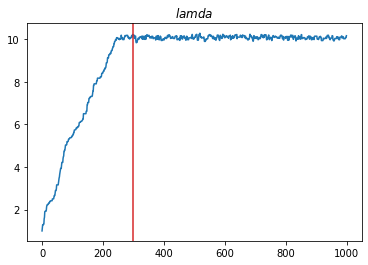

In [18]:
burnin = 300
fig, ax = plt.subplots()
ax.plot(states.position)
ax.set_title(f"$lamda$")
ax.axvline(x=burnin, c="tab:red")
plt.show()

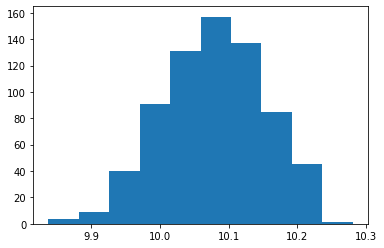

In [19]:
import numpy as np
plt.hist(np.array(states.position[300:]))
plt.show()

In [11]:
with open("../results/weibull_poisson/results_data/MCMC_Blackjax",'wb') as f:
    pickle.dump(states,f)

Now lets see how well the samples are fitting our initial data.

I will just compare with the actual pdf.

<h1> So I am happy :)</h1>